Imports:

In [83]:
import pandas as pd
import scipy
import numpy as np
import stringdb
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import Entrez

Config:

In [ ]:
exp_matrix = pd.read_csv('expression_matrix_simulated.csv', index_col=0)


Classes:

In [9]:
class studyset:
    def __init__(self, expression_data):
        self.expression_data = expression_data
        self.control, self.affected = self.identify_control_and_affected()
        self.control_df = self.expression_data[self.control]
        self.affected_df = self.expression_data[self.affected]
    def identify_control_and_affected(self):
        patient_names = self.expression_data.columns.tolist()
        control = [name for name in patient_names if name.startswith('CTRL')]
        affected = [name for name in patient_names if name.startswith('AFF')]
        return control, affected

In [ ]:

class statistics:
    def compute_basic_stats(self, studyset):
        control_mean = studyset.control_df.mean(axis=1)
        affected_mean = studyset.affected_df.mean(axis=1)
        control_std = studyset.control_df.std(axis=1)
        affected_std = studyset.affected_df.std(axis=1)
        stats_df = pd.DataFrame({
            'Control_Mean': control_mean,
            'Affected_Mean': affected_mean,
            'Control_Std': control_std,
            'Affected_Std': affected_std
        })
        return stats_df
    def compute_differential_expression(self, studyset):
        stats_df = self.compute_basic_stats(studyset)
        stats_df['Fold_Change'] = stats_df['Affected_Mean'] / stats_df['Control_Mean']
        stats_df['Log2_Fold_Change'] = np.log2(stats_df['Fold_Change'])
        p_values = scipy.stats.ttest_ind(studyset.affected_df.T, studyset.control_df.T, axis=0, equal_var=False).pvalue
        stats_df['P_Value'] = p_values
        stats_df['Adjusted_P_Value'] = scipy.stats.false_discovery_control(stats_df['P_Value'], method='bh')
        return stats_df

In [ ]:
class string_db:
    def __init__(self, genes):
        self.genes = genes
        self.network = stringdb.get_network(genes)
    def generate_network_plot(self):
        edges = self.network[self.network['score'] > 0.4][['preferredName_A', 'preferredName_B', 'score']]
        G = nx.Graph()
        for gene in self.genes:
            G.add_node(gene)
        for _, row in edges.iterrows():
            G.add_edge(row['preferredName_A'], row['preferredName_B'], weight=row['score']*10)
        return G
    def plot_network(self, G):
        network_plot = plt.figure(figsize=(10,10))
        weight = [G[u][v]['weight'] for u,v in G.edges()]
        pos = nx.spring_layout(G, k=0.15, iterations=20)
        nx.draw_networkx_nodes(G, pos, node_size=50)
        nx.draw_networkx_edges(G, pos,alpha=0.3)
        nx.draw_networkx_edges(G, pos, width=weight)
        nx.draw_networkx_labels(G, pos, font_size=8)
        plt.title('Gene Interaction Network from STRING-db')
        plt.axis('off')
        plt.show()


In [ ]:
class pybio:
    

In [ ]:
# genes = relevant_genes_adj.index.tolist()
# network = stringdb.get_network(genes)
# edges = network[network['score'] > 0.4]
# edges = edges[['preferredName_A', 'preferredName_B', 'score']]
# G = nx.Graph()
# for gene in genes:
#     G.add_node(gene)
# for _, row in edges.iterrows():
#     G.add_edge(row['preferredName_A'], row['preferredName_B'], weight=row['score'])

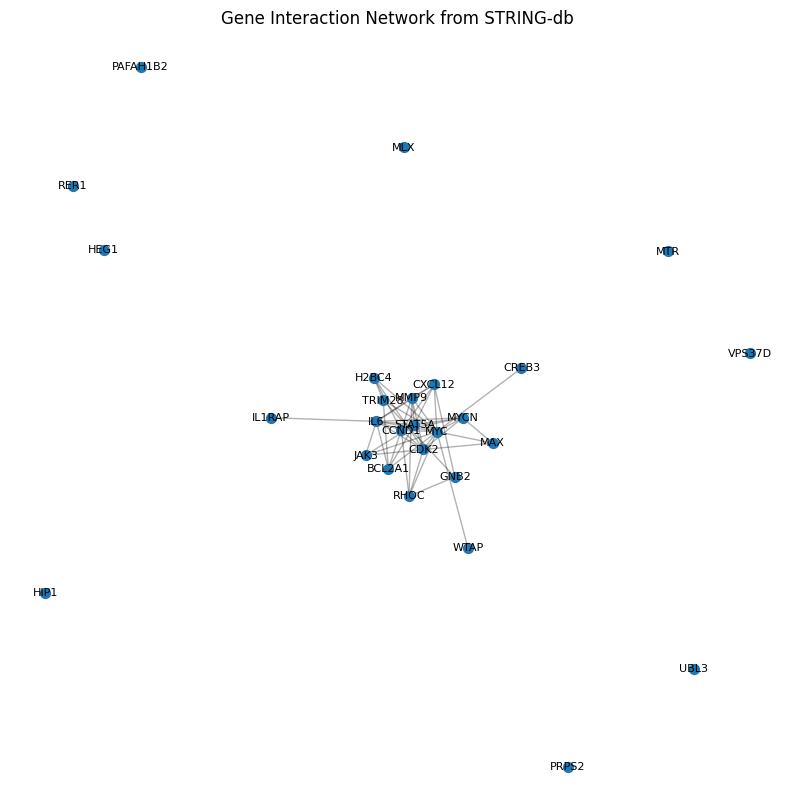

In [ ]:
# network_plot = plt.figure(figsize=(10,10))
# pos = nx.spring_layout(G, k=0.15, iterations=20)
# nx.draw_networkx_nodes(G, pos, node_size=50)
# nx.draw_networkx_edges(G, pos, alpha=0.3)
# nx.draw_networkx_labels(G, pos, font_size=8)
# plt.title('Gene Interaction Network from STRING-db')
# plt.axis('off')
# plt.show()

Workflow:

In [75]:
whodunitcase = studyset(exp_matrix)
stats_df = statistics().compute_differential_expression(whodunitcase)
relevant_genes_adj = stats_df[stats_df['Adjusted_P_Value'] < 0.05].sort_values(by='Adjusted_P_Value')

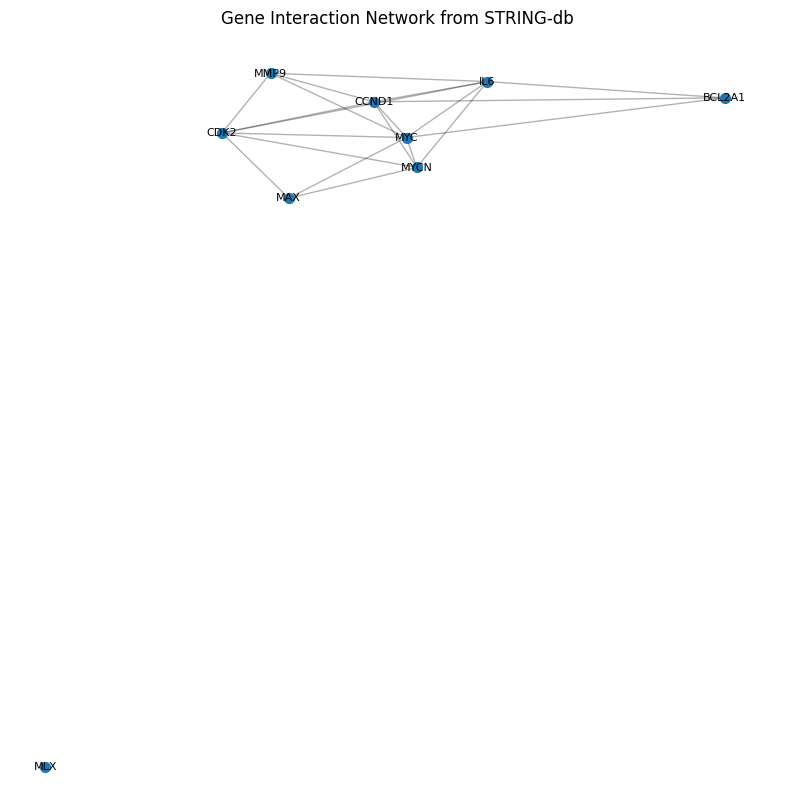

In [76]:
string_genes = relevant_genes_adj.index.tolist()[0:9]
string_object = string_db(genes=string_genes)
string_object.plot_network(string_object.generate_network_plot())

In [ ]:
gene="IL6"
Entrez.email="ryan.potter@his.se"
handle = Entrez.esearch(db="gene", term=gene, retmode="xml")
record = Entrez.read(handle)
handle.close()
handle = Entrez.efetch(db="gene", id=record['IdList'][0], retmode="xml")
record = Entrez.read(handle)
handle.close()

In [89]:
print(record)

{'Count': '1553', 'RetMax': '20', 'RetStart': '0', 'IdList': ['7157', '1956', '348', '7124', '3569', '7422', '22059', '7040', '3091', '2099', '3586', '351', '6774', '1636', '627', '21898', '7421', '29126', '1401', '367'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'IL6[All Fields]', 'Field': 'All Fields', 'Count': '1553', 'Explode': 'N'}, 'GROUP'], 'QueryTranslation': 'IL6[All Fields]'}


In [68]:
relevant_genes_adj.iloc[0:9]

,Control_Mean,Affected_Mean,Control_Std,Affected_Std,Fold_Change,Log2_Fold_Change,P_Value,Adjusted_P_Value
gene,,,,,,,,
CCND1,6.681449,30.377178,0.229942,0.281195,4.546496,2.184755,2.727723e-37,2.564060e-35
IL6,7.528055,35.513764,0.447875,0.208927,4.717522,2.238029,7.622426e-28,3.582540e-26
MYC,10.475267,21.123865,0.427895,0.338124,2.016547,1.011887,5.985758e-26,1.875537e-24
MMP9,6.817448,1.407617,0.311251,0.260897,0.206473,-2.275977,7.105082e-23,1.669694e-21
CDK2,7.074937,1.326024,0.352503,0.266728,0.187426,-2.415611,5.665763e-22,1.065163e-20
MLX,12.239971,18.701424,0.261802,0.379452,1.527898,0.611548,7.637070e-22,1.196474e-20
BCL2A1,6.298973,1.195402,0.233926,0.344120,0.189777,-2.397621,1.350751e-20,1.813865e-19
MAX,11.623600,16.244500,0.395870,0.336704,1.397545,0.482894,3.038814e-19,3.570606e-18
MYCN,7.005809,13.879627,0.407251,0.185750,1.981160,0.986345,7.269613e-19,7.592707e-18
